In [1]:
from mlagents.torch_utils import torch, default_device
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import art3d
import numpy as np
import time

from mlagents.plugins.skeleton_aware_op.dataset import  SkeletonInfo, TemporalMotionData
from mlagents.plugins.skeleton_aware_op.autoencoder_temporal import StaticEncoder, AE, Encoder, Decoder
from mlagents.plugins.skeleton_aware_op.discriminator_temporal import Discriminator
from mlagents.plugins.skeleton_aware_op.loss import calc_chain_velo_loss, calc_ee_loss
from mlagents.plugins.bvh_utils import lafan_utils
from mlagents.plugins.bvh_utils import BVH_mod as BVH
from mlagents.plugins.skeleton_aware_op.options import get_options

from mlagents.plugins.bvh_utils.visualize import skeleton_plot, two_skeleton_plot, motion_animation
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default

%config Completer.use_jedi = False

# setup cuda devices
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
    
torch.device(device)

device(type='cuda', index=0)

## Hyperparameters

In [2]:
options = get_options()

# optimizer parameters
epochs = 80
learning_rate = 0.0002
lr_freq = 0.15
lr_decay = 0.97
betas=(0.9, 0.999)
batch_size = 4

# loss factors
mult_ee  = 1000
mult_adv = 100
mult_glob= 100
mult_chain_velo = 1

real_label = 1
fake_label = 0

isNormalize = True
normalize_velo = False

discrim_epoch=0
dropout = options['drop_percentage']


# limits = [[100,200],[500,600],[0,100]]
limits = [[-50,50],[-50,50],[-50,50]]

## Load Data

In [3]:
data_path = './data/LaFan/Real_Data'
sim_path = './data/Mixamo/Input_Motion'
# test_path = './data/LaFan/Test'

# dataset which constitutes the real data
adv_dataset = TemporalMotionData(data_path, recalculate_mean_var = True, normalize_data = isNormalize,device=device, xyz="zxy")

# train and test input motion fed to the autoencoder
input_dataset = TemporalMotionData(sim_path, recalculate_mean_var = True, normalize_data = isNormalize,device=device)

# divide datasets in a random manner
input_length = len(input_dataset)
train_size = int(input_length * 0.8)
test_size = input_length - train_size
train_input_dataset, test_input_dataset = torch.utils.data.random_split(input_dataset, [train_size, test_size])

train_input_dataloader = torch.utils.data.DataLoader(train_input_dataset, shuffle=True, 
                                                     batch_size=batch_size, num_workers=0)
test_input_dataloader = torch.utils.data.DataLoader(test_input_dataset, shuffle=True, 
                                                    batch_size=batch_size, num_workers=0)

# get skeleton information from datasets                                                    
skdata_data = adv_dataset.skdata
skdata_sim = input_dataset.skdata

[DATASET] final data shape :  torch.Size([979, 88, 16])
[DATASET] input concatenated shape:  torch.Size([15664, 88])
[DATASET] mean shape:  torch.Size([1, 88])
[DATASET] var shape:  torch.Size([1, 88])
[DATASET] mean var shape : torch.Size([2, 88, 1])
[DATASET] final data shape :  torch.Size([60, 112, 16])
[DATASET] input concatenated shape:  torch.Size([960, 112])
[DATASET] mean shape:  torch.Size([1, 112])
[DATASET] var shape:  torch.Size([1, 112])
[DATASET] mean var shape : torch.Size([2, 112, 1])


## Skeleton and Topology preprocessing

In [4]:
encoder_sim = Encoder(skdata_sim.edges)
# use the initialization of encoder_data to get the correct pooling lists
# its forward is not used
encoder_data = Encoder(skdata_data.edges) 
decoder_data = Decoder(encoder_data)

static_encoder_sim = StaticEncoder(skdata_sim.edges).to(device)
static_encoder_data = StaticEncoder(skdata_data.edges).to(device)
discriminator = Discriminator(skdata_data.edges).to(device)

In [5]:
real_label = 1.0
fake_label = 0.0

# this might be the only loss we can use since we don't 
# have a direct reference to a motion
criterion_gan = torch.nn.MSELoss()
criterion_ee = torch.nn.MSELoss()
criterion_glob = torch.nn.MSELoss()
criterion_velo = torch.nn.MSELoss()

# Optimizers
# concatenate parameters used for pose generation
gen_parameters = list(encoder_sim.parameters()) + list(decoder_data.parameters()) \
    + list(static_encoder_sim.parameters()) + list(static_encoder_data.parameters())


gen_optimizer = torch.optim.Adam(gen_parameters, lr=learning_rate, betas=(0.9, 0.999))
discrim_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.9, 0.999))

# scheduler = torch.optim.lr_scheduler.StepLR(gen_optimizer, 10, 0.9)
# cyclic_decay = lambda x : max(0.0001,0.4*(np.cos(lr_freq*x)+1.2)*(lr_decay**x))
# scheduler = torch.optim.lr_scheduler.LambdaLR(gen_optimizer, lr_lambda=cyclic_decay)

Epoch :  0
Batch : 0, Discriminator loss: 0.5036531686782837, Generator loss : 538.6127231214468
Batch : 10, Discriminator loss: 0.4997172951698303, Generator loss : 685.3081158588094
Epoch 0 complete, Train cumulated Discriminator loss : 5.985236644744873, Train cumulated Generator loss : 9791.078529530807
Test Discriminator loss : 0.48708033561706543, Test Generator loss : 562.4221009840363
7 6


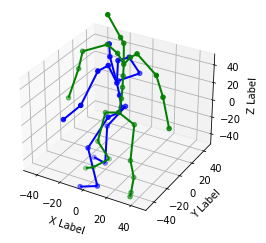

Epoch :  1
Batch : 0, Discriminator loss: 0.49335044622421265, Generator loss : 623.8266927448987
Batch : 10, Discriminator loss: 0.45297369360923767, Generator loss : 618.520844804729
Epoch 1 complete, Train cumulated Discriminator loss : 5.765428066253662, Train cumulated Generator loss : 9277.013179470077
Test Discriminator loss : 0.47427961230278015, Test Generator loss : 537.4064749817414
7 4


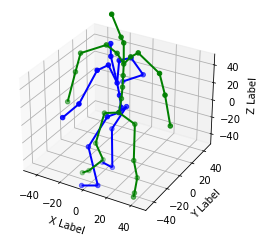

Epoch :  2
Batch : 0, Discriminator loss: 0.4558238089084625, Generator loss : 475.65814238106424
Batch : 10, Discriminator loss: 0.45437783002853394, Generator loss : 447.4869371571006
Epoch 2 complete, Train cumulated Discriminator loss : 5.47369384765625, Train cumulated Generator loss : 8718.868121951233
Test Discriminator loss : 0.46685874462127686, Test Generator loss : 503.86220278510433
3 11


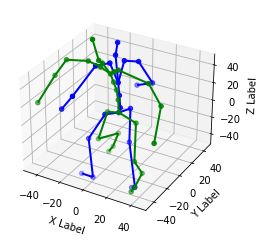

Epoch :  3
Batch : 0, Discriminator loss: 0.4532816410064697, Generator loss : 591.5855451771982
Batch : 10, Discriminator loss: 0.4178888499736786, Generator loss : 342.85892879049214
Epoch 3 complete, Train cumulated Discriminator loss : 5.403075695037842, Train cumulated Generator loss : 7924.668531700544
Test Discriminator loss : 0.45867228507995605, Test Generator loss : 1468.9475128793263
0 15


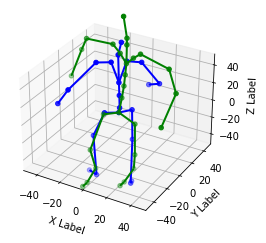

Epoch :  4
Batch : 0, Discriminator loss: 0.4734709858894348, Generator loss : 1104.9141481675479
Batch : 10, Discriminator loss: 0.4312475919723511, Generator loss : 252.0882550140074
Epoch 4 complete, Train cumulated Discriminator loss : 5.43792724609375, Train cumulated Generator loss : 10616.244365633622
Test Discriminator loss : 0.4355345368385315, Test Generator loss : 1633.377601405991
11 4


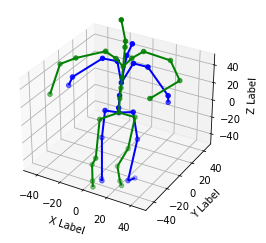

Epoch :  5
Batch : 0, Discriminator loss: 0.4157860279083252, Generator loss : 293.75599526697954
Batch : 10, Discriminator loss: 0.42711523175239563, Generator loss : 206.59625632150815
Epoch 5 complete, Train cumulated Discriminator loss : 5.117667198181152, Train cumulated Generator loss : 7503.89395806885
Test Discriminator loss : 0.39830443263053894, Test Generator loss : 382.19776548124366
10 4


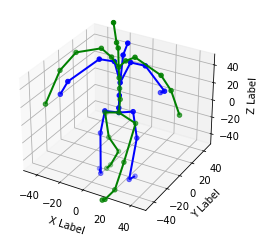

Epoch :  6
Batch : 0, Discriminator loss: 0.38840872049331665, Generator loss : 424.01411246500663
Batch : 10, Discriminator loss: 0.37228554487228394, Generator loss : 365.5905433908573
Epoch 6 complete, Train cumulated Discriminator loss : 4.806228160858154, Train cumulated Generator loss : 5863.980990732799
Test Discriminator loss : 0.3985903263092041, Test Generator loss : 372.9836366178713
0 3


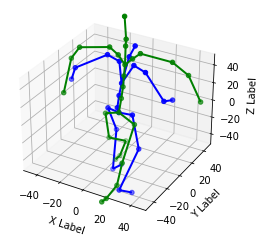

Epoch :  7
Batch : 0, Discriminator loss: 0.37598106265068054, Generator loss : 403.32331576745565
Batch : 10, Discriminator loss: 0.43457576632499695, Generator loss : 501.7753372520671
Epoch 7 complete, Train cumulated Discriminator loss : 4.449428558349609, Train cumulated Generator loss : 5656.996546963407
Test Discriminator loss : 0.3572002649307251, Test Generator loss : 355.8933665568114
0 7


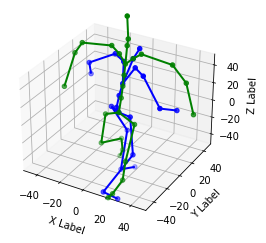

Epoch :  8
Batch : 0, Discriminator loss: 0.3504975438117981, Generator loss : 147.95963926870323
Batch : 10, Discriminator loss: 0.3565273582935333, Generator loss : 611.4140622262909
Epoch 8 complete, Train cumulated Discriminator loss : 4.222842693328857, Train cumulated Generator loss : 5261.030531498606
Test Discriminator loss : 0.3178718090057373, Test Generator loss : 335.4671773335688
10 15


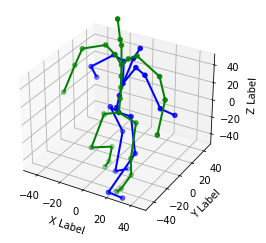

Epoch :  9
Batch : 0, Discriminator loss: 0.46227478981018066, Generator loss : 142.21829164322378
Batch : 10, Discriminator loss: 0.27790185809135437, Generator loss : 252.90155951056212
Epoch 9 complete, Train cumulated Discriminator loss : 4.059820175170898, Train cumulated Generator loss : 4899.972770260673
Test Discriminator loss : 0.31431999802589417, Test Generator loss : 309.0587718522581
5 13


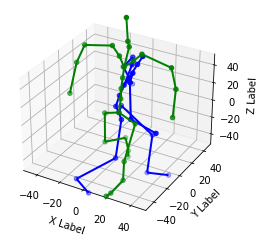

Epoch :  10
Batch : 0, Discriminator loss: 0.2808716893196106, Generator loss : 268.142165077458
Batch : 10, Discriminator loss: 0.3259778916835785, Generator loss : 331.83693321023566
Epoch 10 complete, Train cumulated Discriminator loss : 3.680530309677124, Train cumulated Generator loss : 4560.292217666723
Test Discriminator loss : 0.29086628556251526, Test Generator loss : 286.6652296079691
1 11


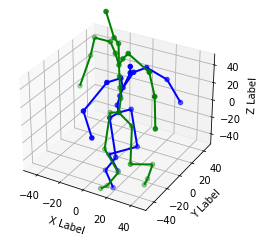

Epoch :  11
Batch : 0, Discriminator loss: 0.32884466648101807, Generator loss : 255.84910861130078
Batch : 10, Discriminator loss: 0.347208172082901, Generator loss : 187.2687825372861
Epoch 11 complete, Train cumulated Discriminator loss : 3.5007662773132324, Train cumulated Generator loss : 4282.291552373229
Test Discriminator loss : 0.2724863886833191, Test Generator loss : 269.561571373265
7 1


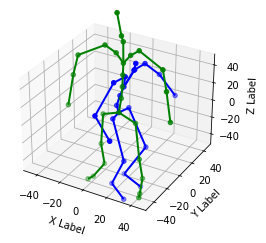

Epoch :  12
Batch : 0, Discriminator loss: 0.2661973834037781, Generator loss : 520.0669507595961
Batch : 10, Discriminator loss: 0.20357051491737366, Generator loss : 253.90038600389008
Epoch 12 complete, Train cumulated Discriminator loss : 3.2083706855773926, Train cumulated Generator loss : 4077.0959336937603
Test Discriminator loss : 0.2637706995010376, Test Generator loss : 260.8309082637831
5 12


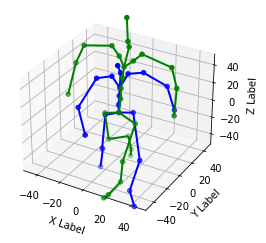

Epoch :  13
Batch : 0, Discriminator loss: 0.2682531476020813, Generator loss : 212.72910517456864
Batch : 10, Discriminator loss: 0.3022567629814148, Generator loss : 194.2420132201595
Epoch 13 complete, Train cumulated Discriminator loss : 2.871277332305908, Train cumulated Generator loss : 3811.226863855807
Test Discriminator loss : 0.24584035575389862, Test Generator loss : 247.930725961561
5 11


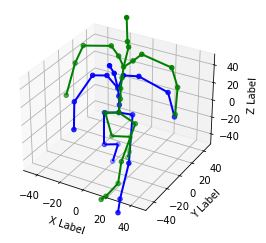

Epoch :  14
Batch : 0, Discriminator loss: 0.25712448358535767, Generator loss : 269.46503892770477
Batch : 10, Discriminator loss: 0.24701286852359772, Generator loss : 362.6646576461207
Epoch 14 complete, Train cumulated Discriminator loss : 2.7479939460754395, Train cumulated Generator loss : 3612.209803276731
Test Discriminator loss : 0.22992949187755585, Test Generator loss : 239.47691730176595
3 15


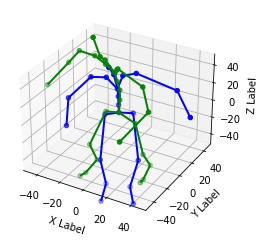

Epoch :  15
Batch : 0, Discriminator loss: 0.17031319439411163, Generator loss : 465.19288056239026
Batch : 10, Discriminator loss: 0.22091424465179443, Generator loss : 432.1603545264749
Epoch 15 complete, Train cumulated Discriminator loss : 2.881084442138672, Train cumulated Generator loss : 4167.078462284082
Test Discriminator loss : 0.2843663692474365, Test Generator loss : 241.95818699699078
5 0


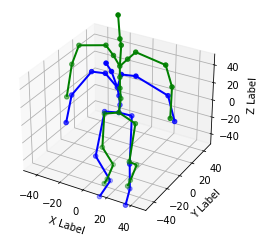

Epoch :  16
Batch : 0, Discriminator loss: 0.2623710632324219, Generator loss : 222.99783900250205
Batch : 10, Discriminator loss: 0.23553334176540375, Generator loss : 699.7481069559672
Epoch 16 complete, Train cumulated Discriminator loss : 2.556973457336426, Train cumulated Generator loss : 3832.1815387158204
Test Discriminator loss : 0.23953841626644135, Test Generator loss : 252.6285891325423
1 14


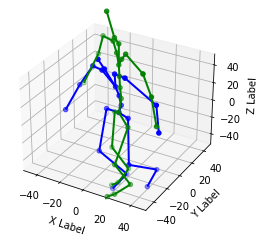

Epoch :  17
Batch : 0, Discriminator loss: 0.17495104670524597, Generator loss : 536.1509317005933
Batch : 10, Discriminator loss: 0.13362927734851837, Generator loss : 182.4878996438489
Epoch 17 complete, Train cumulated Discriminator loss : 2.0591280460357666, Train cumulated Generator loss : 3851.1311703271895
Test Discriminator loss : 0.2131238877773285, Test Generator loss : 245.02474824644142
7 3


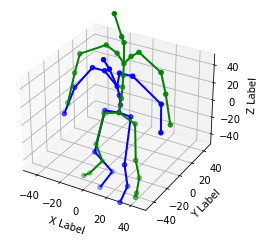

Epoch :  18
Batch : 0, Discriminator loss: 0.15178586542606354, Generator loss : 281.9330598967063
Batch : 10, Discriminator loss: 0.34257423877716064, Generator loss : 144.31895984798697
Epoch 18 complete, Train cumulated Discriminator loss : 2.1287996768951416, Train cumulated Generator loss : 3713.2430548417856
Test Discriminator loss : 0.2010193020105362, Test Generator loss : 236.3001110545141
4 8


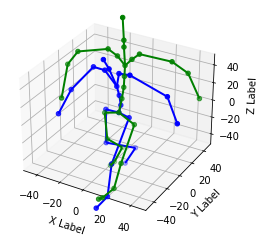

Epoch :  19
Batch : 0, Discriminator loss: 0.09208130836486816, Generator loss : 563.4433409378339
Batch : 10, Discriminator loss: 0.29771870374679565, Generator loss : 197.07964887793153
Epoch 19 complete, Train cumulated Discriminator loss : 2.091780424118042, Train cumulated Generator loss : 3526.020527352845
Test Discriminator loss : 0.1812189519405365, Test Generator loss : 231.60955606254663
4 14


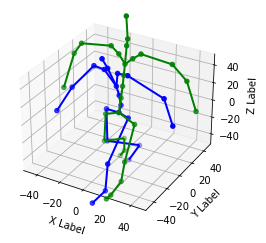

Epoch :  20
Batch : 0, Discriminator loss: 0.09197637438774109, Generator loss : 216.5829159333957
Batch : 10, Discriminator loss: 0.20086227357387543, Generator loss : 600.3507796674963
Epoch 20 complete, Train cumulated Discriminator loss : 1.9188430309295654, Train cumulated Generator loss : 3422.2492176489113
Test Discriminator loss : 0.183572918176651, Test Generator loss : 227.95862785235838
7 4


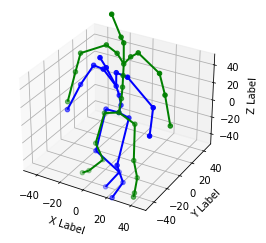

Epoch :  21
Batch : 0, Discriminator loss: 0.19002671539783478, Generator loss : 256.8629036884838
Batch : 10, Discriminator loss: 0.2181701362133026, Generator loss : 131.5291259995736
Epoch 21 complete, Train cumulated Discriminator loss : 2.056372880935669, Train cumulated Generator loss : 3297.4049856739985
Test Discriminator loss : 0.15891830623149872, Test Generator loss : 217.85720712488597
10 1


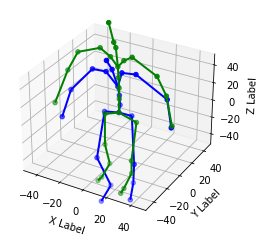

Epoch :  22
Batch : 0, Discriminator loss: 0.06981362402439117, Generator loss : 232.01498968574705
Batch : 10, Discriminator loss: 0.1820727288722992, Generator loss : 130.648939001944
Epoch 22 complete, Train cumulated Discriminator loss : 1.5489685535430908, Train cumulated Generator loss : 3204.5915117540476
Test Discriminator loss : 0.16016922891139984, Test Generator loss : 218.44296846428244
0 2


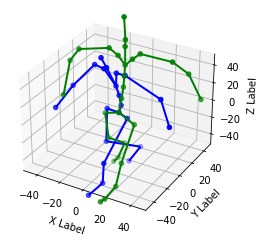

Epoch :  23
Batch : 0, Discriminator loss: 0.11908909678459167, Generator loss : 232.82130494036238
Batch : 10, Discriminator loss: 0.07733695209026337, Generator loss : 395.5075424080934
Epoch 23 complete, Train cumulated Discriminator loss : 2.0876917839050293, Train cumulated Generator loss : 3074.560310251405
Test Discriminator loss : 0.1426946073770523, Test Generator loss : 215.5506838006634
3 8


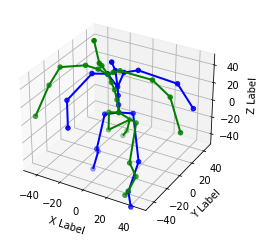

Epoch :  24
Batch : 0, Discriminator loss: 0.08323447406291962, Generator loss : 230.71710519453254


KeyboardInterrupt: 

In [6]:
t = time.localtime()
log_dir = './runs/AE/beans/Ortiz_to_sub1_no_scheduler_time_{}/'.format(time.strftime("%d_%M_%Y-%H_%M", t))
writer = SummaryWriter(log_dir)
text =  """
        parameters: 
        epochs:{}, learning_rate:{}, learning rate decay:{}, 
        learning rate frequency:{}, betas:{}, batch_size:{},  
        mult_ee={}, mult_adv={}, mult_glob={}, mult_velo={},
        isNormalize={}, normalize_velo={}, discrim_epoch={}, dropout={},
        """.format(epochs,learning_rate, lr_decay, lr_freq, betas, batch_size, mult_ee, mult_adv, mult_glob, mult_chain_velo,
                  isNormalize, normalize_velo, discrim_epoch, dropout)
writer.add_text('Hyperparameters',text)

%matplotlib inline

D_cumul = 0
G_cumul = 0

G_loss_adv_cumul  = 0
G_loss_ee_cumul   = 0
G_loss_velo_cumul = 0
G_loss_glob_cumul = 0

for ep in range(epochs):
    print('Epoch : ', ep)
    for i, motion in enumerate(train_input_dataloader):
        
        # reshape motion to [batch_size, window_size, n_joints*channel_size]
        motion = motion.reshape(motion.shape[0], motion.shape[-2], motion.shape[-1]).float()
        curr_batch_size = motion.shape[0]

        # get a frame from the "real" data 
        randinds = np.random.randint(0,len(adv_dataset), curr_batch_size)
        real_motion = adv_dataset[randinds]

        offsets_sim = skdata_sim.offsets.reshape(1, 1, skdata_sim.offsets.shape[0], skdata_sim.offsets.shape[1])
        offsets_sim = offsets_sim.repeat(curr_batch_size, options['window_size'], 1, 1)

        offsets_data = skdata_data.offsets.reshape(1, 1, skdata_data.offsets.shape[0], skdata_data.offsets.shape[1])
        offsets_data = offsets_data.repeat(curr_batch_size, options['window_size'], 1, 1)

        #----------------------------------------------------
        # GENERATE AUTO ENCODED POSE
        #----------------------------------------------------

        # first get the offsets from the static encoder 
        # deep_offsets = static_encoder(torch.tensor(anim.offsets[np.newaxis, :,:]).float())
        deep_offsets_sim = static_encoder_sim(skdata_sim.offsets.reshape(1, skdata_sim.offsets.shape[0], -1))
        deep_offsets_data = static_encoder_data(skdata_data.offsets.reshape(1, skdata_data.offsets.shape[0], -1))

        latent = encoder_sim(motion, deep_offsets_sim)
        res = decoder_data(latent, deep_offsets_data)
        # latent, res = auto_encoder(motion, deep_offsets)
        
        # denormalize data to get correct forward kinematics 
        if isNormalize is True:
            res = adv_dataset.denormalize(res)
            real_motion = adv_dataset.denormalize(real_motion)
            motion = input_dataset.denormalize(motion)

        # TODO: Changed get_pos_info_from_raw definition to take in offsets as a 2d data [num_joints, 3]
        # need to adjust that
        fake_data = lafan_utils.get_pos_info_from_raw(res, skdata_data, offsets_data, options, norm_rot=True )
        fake_pos, fake_pos_local, fake_glob, fake_glob_velo, fake_vel = fake_data

        motion_data = lafan_utils.get_pos_info_from_raw(motion, skdata_sim, offsets_sim, options, norm_rot=False )
        input_pos, input_pos_local, input_glob, input_glob_velo, input_vel = motion_data

        real_data = lafan_utils.get_pos_info_from_raw(real_motion, skdata_data, offsets_data, options, norm_rot=True )
        real_pos, real_pos_local, real_glob, real_glob_velo, real_vel = real_data

        # the GAN update code is mostly taken from :
        #https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html#loss-functions-and-optimizers
        

        # UPDATE DISCRIMINATOR :
        # first do real data batch then fake data
        
        # start adverserial training after a set number of epochs
        if ep >= discrim_epoch:
            loss_real, loss_fake, loss_discrim = discriminator.D_loss(real_pos_local, fake_pos_local, False)
            discrim_optimizer.step()
        
        # UPDATE GENERATOR NETWORK
        # auto_encoder.zero_grad()
        encoder_sim.zero_grad()
        decoder_data.zero_grad()
        static_encoder_sim.zero_grad()
        static_encoder_data.zero_grad()
        
        # Adversial Loss 
        loss_adv = 0
        if ep >= discrim_epoch:
            # use real labels to maximize log(D(G(x))) instead of log(1-D(G(x)))
            label = torch.full((curr_batch_size,), real_label, dtype=torch.float, device=device)
            label.fill_(real_label)
            # use updated discriminator
            output = discriminator(fake_pos_local.float()).view(-1)
            # Calculate the generator's loss and gradients
            loss_adv = criterion_gan(output,label)
            
        # Gobal, Velocity and End Effector Losses
        loss_glob = criterion_glob(fake_glob, input_glob)

        # Get the loss that tries to match the total velocity of every corresponding chain        
        # loss_chain_velo = calc_chain_velo_loss(real_vel, fake_vel, chain_indices, 
        #                                        criterion_velo, normalize_velo = False)
        loss_chain_velo = criterion_velo(fake_glob_velo/skdata_data.height, input_glob_velo/skdata_sim.height)
        loss_ee = calc_ee_loss(input_vel, input_pos_local, fake_vel, fake_pos_local,
                               criterion_ee, skdata_sim, skdata_data)
        

        # combine all the losses together
        loss_gen =  loss_adv*mult_adv + loss_ee*mult_ee + \
        loss_glob*mult_glob + loss_chain_velo*mult_chain_velo
        
        # update gradient
        loss_gen.backward()
        gen_optimizer.step()
        
        # record losses 
        D_cumul += loss_discrim
        G_cumul += loss_gen
        
        G_loss_adv_cumul += loss_adv
        G_loss_ee_cumul  += loss_ee
        G_loss_velo_cumul+= loss_chain_velo
        G_loss_glob_cumul+= loss_glob

        if(i % 10 == 0):
            print("Batch : {}, Discriminator loss: {}, Generator loss : {}".format(i, loss_discrim, loss_gen))
    
    # scheduler.step()

    N = len(train_input_dataset)

    writer.add_scalar('Train/D_loss', D_cumul/N, ep)
    writer.add_scalar('Train/G_loss', G_cumul/N, ep)
    writer.add_scalar('Train/adv_loss', G_loss_adv_cumul/N *mult_adv , ep)
    writer.add_scalar('Train/ee_loss',  G_loss_ee_cumul/N  *mult_ee, ep)
    writer.add_scalar('Train/velo_loss',G_loss_velo_cumul/N*mult_chain_velo, ep)
    writer.add_scalar('Train/glob_loss',G_loss_glob_cumul/N*mult_glob, ep)
    
    # writer.add_scalar('Hyperparameter/learning_rate', scheduler.get_last_lr()[0], ep)

    print("Epoch {} complete, Train cumulated Discriminator loss : {}, Train cumulated Generator loss : {}".format(ep, D_cumul, G_cumul) )
    
    D_cumul = 0
    G_cumul = 0
    
    G_loss_adv_cumul  = 0
    G_loss_ee_cumul   = 0
    G_loss_velo_cumul = 0
    G_loss_glob_cumul = 0
    
    #----------------------------------------------------------------------
    # TEST
    #----------------------------------------------------------------------
    with torch.no_grad():
        
        # TEST ON A RANDOM FRAME
        curr_batch_size = len(test_input_dataset)
        test_data = test_input_dataset[:].float()

        # get a frame from the "real" data 
        randinds = np.random.randint(0,len(adv_dataset), curr_batch_size)
        real_motion = adv_dataset[randinds]
        
        motion = test_data        
        offsets_sim = skdata_sim.offsets.reshape(1, 1, skdata_sim.offsets.shape[0], skdata_sim.offsets.shape[1])
        offsets_sim = offsets_sim.repeat(curr_batch_size, options['window_size'], 1, 1)

        offsets_data = skdata_data.offsets.reshape(1, 1, skdata_data.offsets.shape[0], skdata_data.offsets.shape[1])
        offsets_data = offsets_data.repeat(curr_batch_size, options['window_size'], 1, 1)
    
        # first get the offsets from the static encoder 
        # deep_offsets = static_encoder(torch.tensor(anim.offsets[np.newaxis, :,:]).float())
        deep_offsets_sim = static_encoder_sim(skdata_sim.offsets.reshape(1, skdata_sim.offsets.shape[0], -1))
        deep_offsets_data = static_encoder_data(skdata_data.offsets.reshape(1, skdata_data.offsets.shape[0], -1))

        latent = encoder_sim(motion, deep_offsets_sim)
        res = decoder_data(latent, deep_offsets_data)
        # latent, res = auto_encoder(motion, deep_offsets)
        
        # denormalize data to get correct forward kinematics 
        if isNormalize is True:
            res = adv_dataset.denormalize(res)
            real_motion = adv_dataset.denormalize(real_motion)
            motion = input_dataset.denormalize(motion)


        fake_data = lafan_utils.get_pos_info_from_raw(res, skdata_data, offsets_data, options, norm_rot=True )
        fake_pos, fake_pos_local, fake_glob, fake_glob_velo, fake_vel = fake_data

        motion_data = lafan_utils.get_pos_info_from_raw(motion, skdata_sim, offsets_sim, options, norm_rot=False )
        input_pos, input_pos_local, input_glob, input_glob_velo, input_vel = motion_data

        real_data = lafan_utils.get_pos_info_from_raw(real_motion, skdata_data, offsets_data, options, norm_rot=True )
        real_pos, real_pos_local, real_glob, real_glob_velo, real_vel = real_data

        #-----------------
        # GET DISCRIM LOSS
        #-----------------    
        loss_real, loss_fake, loss_discrim = discriminator.D_loss(real_pos_local, fake_pos_local, True)
                
        #-----------------
        # GET GEN LOSS
        #-----------------
        # use real labels to maximize log(D(G(x))) instead of log(1-D(G(x)))
        label = torch.full((curr_batch_size,), real_label, dtype=torch.float, device=device)
        label.fill_(real_label)
        # use updated discriminator
        output = discriminator(fake_pos_local.float()).view(-1)

        # Calculate the generator's loss and gradients
        loss_adv = criterion_gan(output,label)
        loss_glob = criterion_glob(fake_glob, input_glob)

        # input_vel, fake_vel = lafan_utils.get_batch_velo(input_pos_local, fake_pos_local, skdata_sim.frametime)
        # loss_chain_velo = calc_chain_velo_loss(real_vel, fake_vel, chain_indices, 
        #                                        criterion_velo, normalize_velo = False)
        loss_chain_velo = criterion_velo(fake_glob_velo/skdata_data.height, input_glob_velo/skdata_sim.height)
        loss_ee = calc_ee_loss(input_vel, input_pos_local, fake_vel, fake_pos_local,
                               criterion_ee, skdata_sim, skdata_data)
        
        # combine all the losses together
        loss_gen =  loss_adv*mult_adv + loss_ee*mult_ee + \
        loss_glob*mult_glob + loss_chain_velo*mult_chain_velo
        

        N = curr_batch_size
        writer.add_scalar('Test/D_loss', loss_discrim/N, ep)
        writer.add_scalar('Test/G_loss', loss_gen/N, ep)
        writer.add_scalar('Test/adv_loss', loss_adv/N       *mult_adv , ep)
        writer.add_scalar('Test/ee_loss',  loss_ee/N        *mult_ee , ep)
        writer.add_scalar('Test/velo_loss',loss_chain_velo/N*mult_chain_velo, ep)
        writer.add_scalar('Test/glob_loss',loss_glob/N      *mult_glob, ep)
        
        # print one
        batch_ind = np.random.randint(0,curr_batch_size)
        frame_ind = np.random.randint(0,options['window_size'])

        print("Test Discriminator loss : {}, Test Generator loss : {}".format(loss_discrim, loss_gen) )
        print(batch_ind, frame_ind)
        
        # input_pos[batch_ind,frame_ind,:,2] = -input_pos[batch_ind,frame_ind,:,2] 
        two_skeleton_plot(fake_pos[batch_ind,frame_ind,:,:].cpu().detach(),
                          input_pos[batch_ind,frame_ind,:,:].cpu().detach(),
                          skdata_data.edges, skdata_sim.edges,
                          'b','g', limits=limits)
        # skeleton_plot(real_pos[0,0,:,:].cpu().detach(), skdata_data.edges, 'y', limits=limits)


writer.close()

In [21]:

from IPython.display import HTML
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter
%matplotlib qt
# from matplotlib import rc

In [22]:
ind = 10
_, global_fake_pos = lafan_utils.get_global_position_from_velocity(torch.tensor([0,0,0]), 
                                                                   fake_glob_velo[ind], skdata_data.frametime,
                                                                   fake_pos[ind])
_, global_input_pos = lafan_utils.get_global_position_from_velocity(torch.tensor([0,0,0]), 
                                                                   input_glob_velo[ind], skdata_data.frametime, 
                                                                   input_pos[ind])

In [23]:
# global_real_pos = np.load('real_pos.npy')
# global_fake_pos = np.load('fake_pos.npy')
# global_real_pos = torch.tensor(global_real_pos)
# global_fake_pos = torch.tensor(global_fake_pos)

anim = motion_animation(global_input_pos.cpu().detach(), global_fake_pos.cpu().detach(), skdata_sim.edges, skdata_data.edges, limits)
# Set up formatting for the movie files
anim.save("C:/users/nicol/Work/Master/dissertation/results/Ortiz_to_Lafan_with_adv_{}.gif".forma(time), writer=PillowWriter(fps=15))

HTML(anim.to_jshtml())
# plt.show()
# %matploplib inline

c:\users\nicol\work\master\dissertation\ml-agents\ml-agents\mlagents\plugins\bvh_utils\visualize.py:104: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = p3.Axes3D(fig)
